In [1]:
from facenet_pytorch import MTCNN
from facenet_pytorch import InceptionResnetV1

import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import glob
import warnings
import tqdm
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import DataLoader

# Building a Facial Recognition system from pre-trained networks

You have been given extensive examples in the lab webpage, so please refer to those while completing this notebook.  Begin by installing the git repo.

### Understanding your networks

Take a picture with your phone of somebody in the class, and upload that picture to this notebook.  Open the image, and display it with `plt.imshow(img)`.

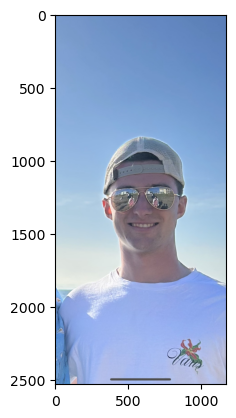

In [5]:
img = Image.open('caleb.jpg')
img.load()
plt.imshow(img)

Now, run it through your facial detector.  The output will be a tensor, suppose it's called `img_cropped`. Print out its shape, and then display the image. You can display it with `plt.imshow(img_cropped.permute(1,2,0))`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76953125..0.99609375].


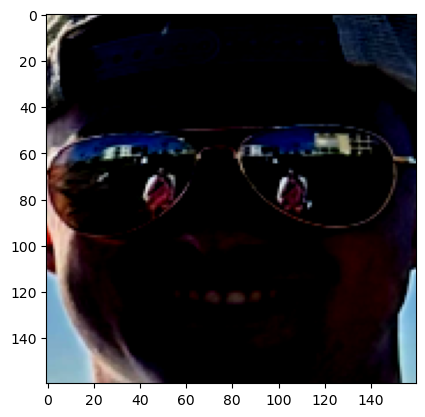

In [6]:
mtcnn = MTCNN(keep_all=True)
mtcnn.eval()
cropped_img = mtcnn(img)
plt.imshow(cropped_img[0].permute(1,2,0))

Now, create an embedding of that face, and print out its shape.

In [7]:
resnet = InceptionResnetV1(pretrained='vggface2')
resnet.eval()
embedding = resnet(cropped_img).detach().numpy()

### Getting your gallery

Using the S3 bucket `s3://mlspace-data-521454461163/project/10FacialRecognition/datasets/midsfaces/`, for all midshipmen currently taking SD312, create a list of all the images, and then a numpy array of all the embeddings of their cropped faces, where `embeddings[0]` is a row vector containing the embedding of `images[0]` from your list of images.

In [8]:
# create array of all photos in dataset
PATH = 'photos/'
files = glob.glob(PATH + '*')

# lists for all embeddings
embeddings = []

# loop through every photo file
for file in files:

    # open and load the image
    image = Image.open(file)
    image.load()

    # add embedding to list (as numpy array, not tensor)
    embeddings.append(resnet(mtcnn(image)).detach().numpy()[0])

`.fit()` a sklearn `NearestNeighbor` object to your trained embeddings.  Let's keep the top-5 closest faces.

In [9]:
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(embeddings)

NearestNeighbors(metric='euclidean')

### Building your recognition system

Now, find the five faces which are closest in embedding space to your picture.

To help you visualize how this is working, write a function that displays first the probe image, and then the five gallery images closest to that probe image.

In [10]:
def findSimilarFaces(face):

    # print out given photo
    org = Image.open(face)
    org.load()
    plt.imshow(org)
    plt.show()

    # generate embedding
    emb = resnet(mtcnn(org)).detach().numpy()
    

    # use knn object to find 5 nearest images (and respective euclidean distances in the latent space)
    distances, indeces = knn.kneighbors([emb[0]])
    distances = distances[0]
    indeces = indeces[0]

    # loop through closest neighbors
    for i, index in enumerate(indeces):

        # display image
        image = Image.open(files[index])
        image.load()
        plt.imshow(image)
        plt.show()

        # display distance
        print(f'Euclidean Distance in latent space: {distances[i]}')

Because we specifically got the entire dataset of all midshipmen, I decided to just see how accurate the model was with various pictures of my company mates and friends.

In [ ]:
findSimilarFaces('joe.jpg')

Collect more pictures of people in the class.  Find some with people wearing a hat, or a Halloween costume, or a covid mask, or a terrible mustache.  How well do they work?

Expand to the full class of 2025 for your gallery images.  Then expand to all midshipmen in the dataset.  How does your accuracy change?